# Sentiment Classification


In [1]:
from time import time
import itertools
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

Using TensorFlow backend.
C:\Users\smazh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\smazh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\smazh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\smazh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

## Loading the dataset

In [3]:
from keras.datasets import imdb

vocab_size = 10000 #vocab size

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

In [4]:
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

## Train test split

In [5]:
#load dataset as a list of ints
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
#make all sequences of the same length
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data =  pad_sequences(test_data, maxlen=maxlen)

train_len = [len(sequence) for sequence in x_train]
test_len = [len(sequence) for sequence in x_test]

In [6]:
def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
sentiments = {1: 'Positive', 0: 'Negative'}
review_id1 = np.random.choice(train_len)
interprete_review(train_data[review_id1])
print('\nThe sentiment for the above review is:', sentiments.get(train_labels[review_id1]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? people forget that there have been several king kong ? ? king kong vs godzilla king kong 1976 they all ripoff one another but yeti stands on its own it only borrows one element from king kong and that is the ? attraction with one female br br the yeti myth is based on bigfoot not like king kong and ? have been fascinated it at one time they did exist but there is no scientific data to prove it br br this movie is hard to find but its worth watching it the first time i watched it was on ? mistress of the dark shows in the early 1980's it sent chills down my spine as a kid especially when the yeti got mad i saw it again around 1 ? on abc about 2 to ? ago seeing it again made me appreciate it more it has some overall good effects for its time and the story involves a mute boy and his dog and an evil businessman person w


## Build Keras Sequential Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [7]:
maxlen = 1500  #number of word used from each review
# maxlen = max([len(sequence) for sequence in np.concatenate([train_data, test_data])])

#make all sequences of the same length
x_train = pad_sequences(train_data, maxlen=maxlen)
x_test =  pad_sequences(test_data, maxlen=maxlen)

y_train = train_labels
y_test = test_labels

print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)

x_train : (25000, 1500)
x_test  : (25000, 1500)


In [8]:
# Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

In [9]:
# Classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

In [10]:
# Categorical Crossentropy Loss vs Epochs
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()


### Sequential Model : Embedding + Flatten + Dense + Adam + Sigmoid

In [11]:
embedding_dim = 300

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 450000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 450001    
Total params: 3,450,001
Trainable params: 3,450,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model
epochs = 5
batches = 512
start = time()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batches, 
                    validation_split=0.2, validation_data = (x_test, y_test))


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 51s 2ms/step - loss: 1.1040 - accuracy: 0.5215 - val_loss: 0.6180 - val_accuracy: 0.7266
Epoch 2/5
25000/25000 [==============================] - 50s 2ms/step - loss: 0.4104 - accuracy: 0.8519 - val_loss: 0.3189 - val_accuracy: 0.8705
Epoch 3/5
25000/25000 [==============================] - 50s 2ms/step - loss: 0.2074 - accuracy: 0.9278 - val_loss: 0.2849 - val_accuracy: 0.8796
Epoch 4/5
25000/25000 [==============================] - 50s 2ms/step - loss: 0.1296 - accuracy: 0.9651 - val_loss: 0.2745 - val_accuracy: 0.8845
Epoch 5/5
25000/25000 [==============================] - 50s 2ms/step - loss: 0.0783 - accuracy: 0.9866 - val_loss: 0.2800 - val_accuracy: 0.8820


#### Analyze Classification Summary

Test score: 0.28003682378292083
Test accuracy: 0.8819599747657776


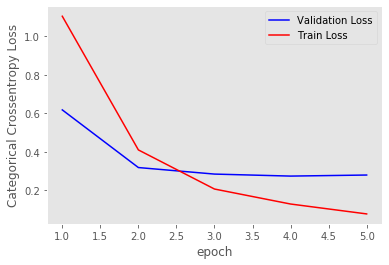

In [13]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

Testing accuracy: 88.20%
________________________________________________________________________________
Confusion matrix:
 [[11083  1417]
 [ 1534 10966]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     12500
           1       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

________________________________________________________________________________
Precision-Recall curve


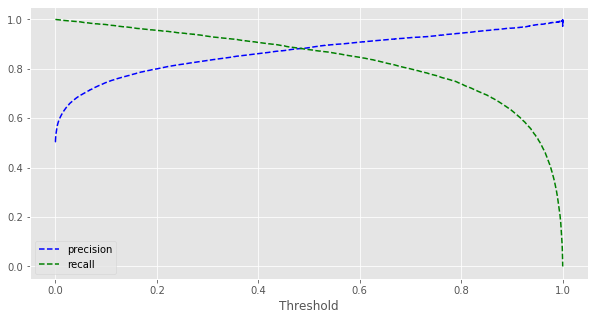

In [14]:
y_pred = model.predict_classes(x_test)
y_proba = model.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

In [15]:
# Predict for a random pre-defined review from IMDB dataset
review_id = np.random.choice(test_len)

interprete_review(test_data[review_id])

prediction = model.predict_classes(pad_sequences([test_data[review_id]], maxlen=maxlen))

print('\nThe ACTUAL sentiment    :'+ sentiments.get(test_labels[review_id]))
print('\nThe PREDICTED sentiment :' + sentiments.get(prediction[0][0]))

runs him over br br the cop quickly starts telling nicole that he's a ? who's lucky to be breathing still yet he strangely doesn't die for quite a while the two of them do some more pointless talking and the all important fact that he has a gun is annoyingly not even mentioned for too long a time when the two of them finally try to use the gun nicole ? wastes most of her bullets ? shooting at a door when the killer was possibly behind it with two bullets left the policeman tells nicole to use one to him she fires one into his mouth and he lays still for a few moments with a ? blown out of his head then he suddenly and inexplicably yells out you missed and she has to shoot him again completely cheap attempt at shock br br nicole finally confronts the fails the movie ends with a scene taking place not long from then with a woman arriving at the now strangely much more active rest stop in the bathroom building she hears nicole crying for help in the closet locked in like tracy was she get


## Retrive the output of each layer in keras for a given single test sample from the trained model you built
Let's create a generic method to print the name, size and output of each layer in Keras model.

In [16]:
def layer_outs_for_single_instance(model, instance):
    outputs = [layer.output for layer in model.layers]                  # all layer outputs
    function = K.function([model.input, K.learning_phase()], outputs)   # evaluation function
    
    if instance.any():
        layer_outs = function([np.array([instance,]), 1.])
        for idx, out in enumerate(layer_outs):
            print('Layer :', idx + 1)
            print('Name   :', model.layers[idx].name)
            print('Shape : ' + str(out.shape))
            print(out)

In [17]:
layer_outs_for_single_instance(model, x_test[np.random.choice(test_len)])

Layer : 1
Name   : embedding_1
Shape : (1, 1500, 300)
[[[ 1.9481349e-03  1.9192958e-05 -2.7758654e-03 ...  1.9856675e-03
   -2.9194236e-03 -1.9796751e-03]
  [ 1.9481349e-03  1.9192958e-05 -2.7758654e-03 ...  1.9856675e-03
   -2.9194236e-03 -1.9796751e-03]
  [ 1.9481349e-03  1.9192958e-05 -2.7758654e-03 ...  1.9856675e-03
   -2.9194236e-03 -1.9796751e-03]
  ...
  [-2.4660781e-02 -6.2079784e-02 -1.7079819e-02 ...  8.7658599e-02
   -6.1194096e-02 -1.1752298e-02]
  [-2.6563084e-02  1.6203255e-03 -2.0029746e-02 ... -4.1858017e-02
   -4.6847623e-02  4.4409204e-02]
  [-4.2466153e-03 -2.6367970e-02 -4.4229116e-02 ...  2.9580105e-02
   -7.2158100e-03  1.9263087e-02]]]
Layer : 2
Name   : flatten_1
Shape : (1, 450000)
[[ 1.9481349e-03  1.9192958e-05 -2.7758654e-03 ...  2.9580105e-02
  -7.2158100e-03  1.9263087e-02]]
Layer : 3
Name   : dense_1
Shape : (1, 1)
[[0.09005297]]
